# Face mask detection

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DiouaneAbdallah/face-mask-detection/blob/main/faceMaskDetection.ipynb)

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=4b14edd63de15f1bccdb0770bb6dd88e45a892e52dae141997bde5264201c63d
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 12.1 GB  | Proc size: 1.0 GB
GPU RAM Free: 11296MB | Used: 145MB | Util   1% | Total 11441MB


## import the necessary packages



In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

## load and pre-process our data

In [3]:
!git clone https://github.com/prajnasb/observations

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 33.46 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [4]:
!ls observations/experiements/data/

with_mask  without_mask


In [5]:
imagePaths = list(paths.list_images('observations/experiements/data/'))
data = []
labels = []

for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	data.append(image)
	labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

### perform one-hot encoding on the labels


In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### partition the data into training and testing splits

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

### construct the training image generator

In [8]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

## build the model

### initialize the learning rate, number of epochs, and batch size

In [9]:
# learning rate
INIT_LR = 1e-4
# num of epochs
EPOCHS = 20
# batch size
BS = 32

### load the MobileNetV2 network

In [10]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 0s 0us/step


### construct the head of the model that will be placed on top of thethe base model

In [11]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

### compile our model

In [12]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

## train the head of the network

In [13]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 36s 495ms/step - loss: 0.5084 - accuracy: 0.7837 - val_loss: 0.1948 - val_accuracy: 0.9746
Epoch 2/20
34/34 [==============================] - 14s 407ms/step - loss: 0.1978 - accuracy: 0.9588 - val_loss: 0.0922 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 15s 440ms/step - loss: 0.1100 - accuracy: 0.9841 - val_loss: 0.0589 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 14s 423ms/step - loss: 0.0738 - accuracy: 0.9878 - val_loss: 0.0438 - val_accuracy: 0.9891
Epoch 5/20
34/34 [==============================] - 14s 410ms/step - loss: 0.0581 - accuracy: 0.9906 - val_loss: 0.0371 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 14s 420ms/step - loss: 0.0464 - accuracy: 0.9934 - val_loss: 0.0307 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 14s 408ms/step - loss: 0.0436 - accuracy: 0.9897 - val_loss: 0.0281 - val_accuracy: 0.9964

## evaluate the model

In [14]:
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.99      0.99       138
without_mask       0.99      1.00      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



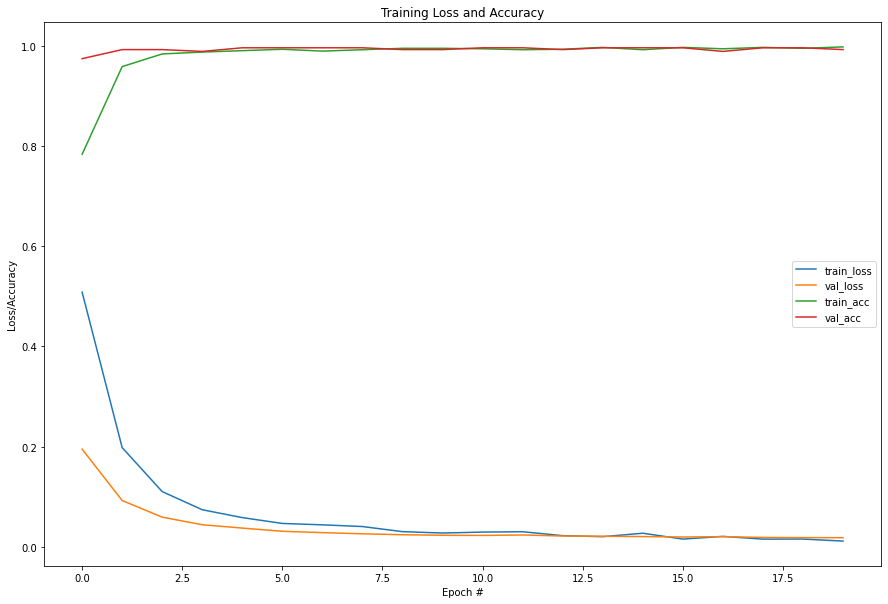

In [15]:
N = EPOCHS
plt.figure(figsize=(15,10))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best",  )

In [16]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 5.1 MB/s 


In [45]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
from mtcnn.mtcnn import MTCNN

def mask_func(image):
    detector = MTCNN()
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(img)

    x, y, w, h = faces[0]['box']
    x1, y1 = x + w, y + h

    img0 = cv2.resize(img,(224,224))
    img0 = img0.reshape(1,224,224,3)

    (mask, withoutMask) = model.predict(img0)[0]

    label = "Mask" if mask > withoutMask else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (255, 0, 0)
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

    cv2.putText(img, label, (x, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    img = cv2.rectangle(img, (x, y), (x1, y1), color, 2)

    plt.figure(figsize=(15, 9))
    plt.imshow(img)
    plt.show()

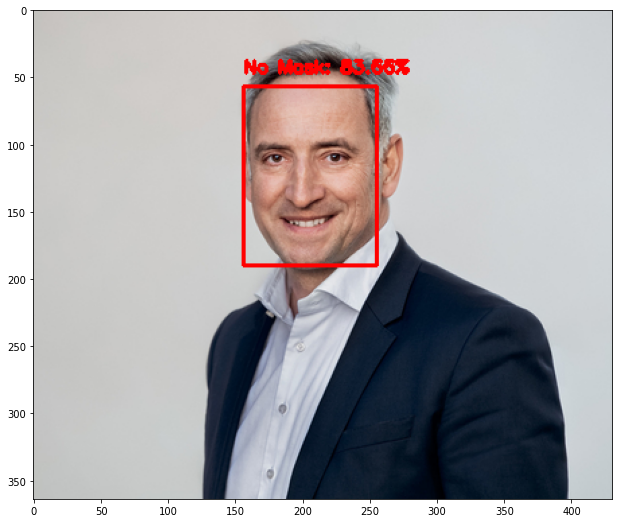

In [48]:
mask_func('image1.jpg')

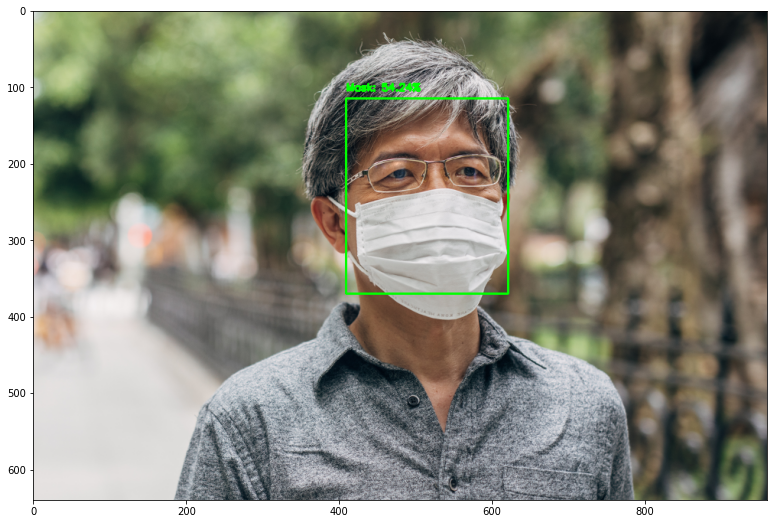

In [50]:
mask_func('image0.png')

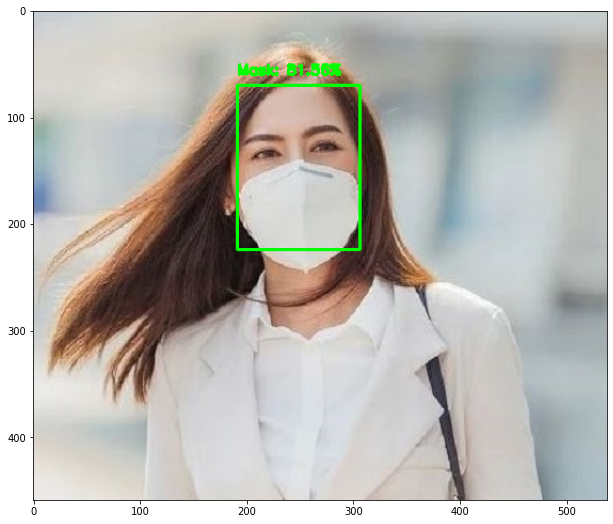

In [55]:
mask_func('image8.jpg')

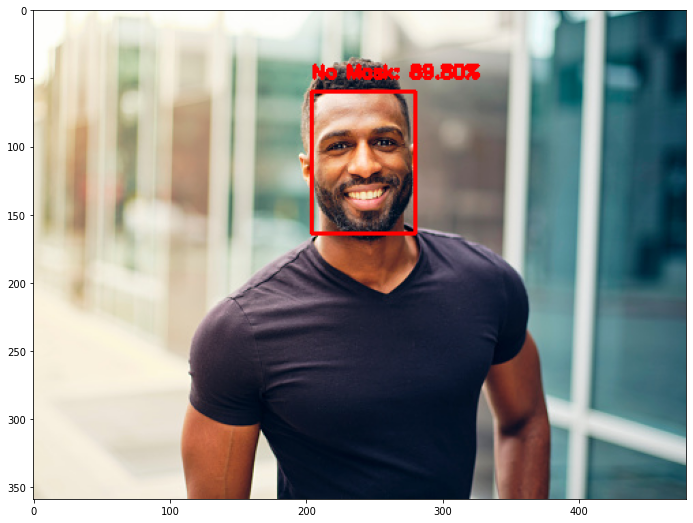

In [56]:
mask_func('image3.jpg')

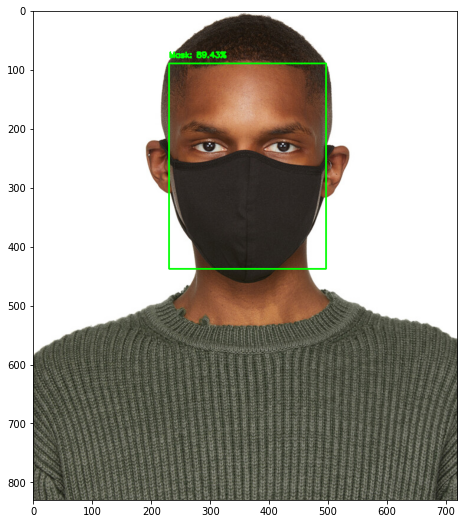

In [61]:
mask_func('image9.jpg')